# Testing VPU & Signal Reconstruction

The aim of this blog post is to test that we can correctly reconstruct a simple signal. And also to better understand the data of each stage.

## Test Binary Vectors
Let's test first by randomly selecting between [0, 0] and [1, 1] vectors.

In [1]:
from src.var_processor.vpu import VPU, VPUBinary
import random
import numpy as np

In [2]:
random.random()

0.4364885101236424

In [3]:
def rand_same():
    a = np.empty([2, 1])
    a.fill(np.random.randint(2))
    return a

In [4]:
def rand_diff():
    a = np.zeros([2, 1])
    index = np.random.randint(2)
    a[index] = 1
    return a

In [5]:
print(rand_same(), rand_same().shape)

[[0.]
 [0.]] (2, 1)


In [6]:
print(rand_diff(), rand_diff().shape)

[[0.]
 [1.]] (2, 1)


In [7]:
vpu = VPU(2)
print(vpu.cu.covariance, vpu.pi.ev)
for _ in range(0, 1000):
    vpu.update_cov(rand_same())
    vpu.pi.iterate(cov=vpu.cu.covariance)
print(vpu.cu.covariance, vpu.pi.ev)

[[0. 0.]
 [0. 0.]] [[0.27118799]
 [0.9625264 ]]
[[0.24668139 0.24668139]
 [0.24668139 0.24668139]] [[0.70710678]
 [0.70710678]]


In [8]:
print(vpu.pi.eigenvalue, vpu.pi.eigenvector)

[[0.49336278]] [[0.70710678]
 [0.70710678]]


In [9]:
np.sqrt(vpu.pi.eigenvalue)

array([[0.70239788]])

In [10]:
np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))

array([[0.49667031],
       [0.49667031]])

Does the above expression thus give you something to do with the probability for the vector?

In [11]:
np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean

array([[0.97767031],
       [0.97767031]])

We can use this to same with x = 1 or 0? Or x = -1, or 1?

In [12]:
print(
    np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean,
    -1*np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
)

[[0.97767031]
 [0.97767031]] [[-0.01567031]
 [-0.01567031]]


Yes - x = -1 or 1 or random value within this range.

In [13]:
# Adapt to test

vpu = VPU(2)
for _ in range(0, 1000):
    vpu.update_cov(rand_same())
    vpu.pi.iterate(cov=vpu.cu.covariance)
# Check all values of covariance matrix are the same
print(vpu.cu.covariance, vpu.cu.covariance[0])
assert np.allclose(vpu.cu.covariance, vpu.cu.covariance[0])
# Check eigenvector has values of root 2
print(vpu.pi.eigenvector, 1/np.sqrt(2))
assert np.allclose(vpu.pi.eigenvector, 1/np.sqrt(2))
sample_1 = np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
sample_minus1 = -1*np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
assert np.allclose(sample_1, np.array([1, 1]), rtol=0.05, atol=0.05)
assert np.allclose(sample_minus1, np.array([0, 0]), rtol=0.05, atol=0.05)

[[0.24699319 0.24699319]
 [0.24699319 0.24699319]] [0.24699319 0.24699319]
[[0.70710678]
 [0.70710678]] 0.7071067811865475


In [14]:
1/np.sqrt(2)

0.7071067811865475

In [15]:
vpu = VPU(2)
print(vpu.cu.covariance, vpu.pi.ev, sep="\n", end="\n\n")
for _ in range(0, 1000):
    vpu.update_cov(rand_diff())
    vpu.pi.iterate(cov=vpu.cu.covariance)
print(vpu.cu.covariance, vpu.pi.ev, vpu.pi.eigenvalue, sep="\n", end="\n\n")
print(
    vpu.cu.mean,
    np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue)), 
    np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean,
    sep="\n",
    end="\n\n"
)

[[0. 0.]
 [0. 0.]]
[[0.03446228]
 [0.999406  ]]

[[ 0.24635218 -0.24635218]
 [-0.24635218  0.24635218]]
[[-0.70710678]
 [ 0.70710678]]
[[0.49270436]]

[[0.526]
 [0.474]]
[[-0.49633878]
 [ 0.49633878]]
[[0.02966122]
 [0.97033878]]



How would we get a sample of [0, 1] if x = 0 then we just have mean. Ah - x needs to be between -1 and 1.

In [16]:
# Forward Pass
a = rand_diff()
print(a, np.dot(vpu.pi.eigenvector.T, a))

[[1.]
 [0.]] [[-0.70710678]]


In [17]:
np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean

array([[0.02966122],
       [0.97033878]])

In [18]:
-1*np.dot(vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean

array([[ 1.02233878],
       [-0.02233878]])

In [19]:
# Adapt to test

vpu = VPU(2)
for _ in range(0, 1000):
    vpu.update_cov(rand_diff())
    vpu.pi.iterate(cov=vpu.cu.covariance)
# Check diagonal values of covariance matrix are the same
# Use https://docs.scipy.org/doc/numpy/reference/generated/numpy.diagonal.html
print(vpu.cu.covariance[0], -1*vpu.cu.covariance[-1])
assert np.allclose(vpu.cu.covariance[0], -1*vpu.cu.covariance[-1])
# Check eigenvector has values of root 2
print(vpu.pi.eigenvector, 1/np.sqrt(2))
assert np.allclose(np.abs(vpu.pi.eigenvector), 1/np.sqrt(2))
# Check different signs
assert np.allclose(vpu.pi.eigenvector[0], -1*vpu.pi.eigenvector[1])
sample_1 = np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
sample_minus1 = -1*np.dot(
        vpu.pi.eigenvector, np.sqrt(vpu.pi.eigenvalue))+vpu.cu.mean
print(sample_1, np.flipud(sample_minus1))
assert np.allclose(sample_1, np.flipud(sample_minus1), rtol=0.1, atol=0.1)

[ 0.2468632 -0.2468632] [ 0.2468632 -0.2468632]
[[ 0.70710678]
 [-0.70710678]] 0.7071067811865475
[[0.99085329]
 [0.00914671]] [[ 1.00285329]
 [-0.00285329]]


## Test Reconstruction

So we do a forward pass - get the output r, reconstruct then subtract.

In [20]:
# Setup VPU
vpu = VPU(2)
for _ in range(0, 1000):
    vpu.update_cov(rand_same())
    vpu.pi.iterate(cov=vpu.cu.covariance)

In [21]:
# Test forward pass with no processing
ran = rand_same()
r = vpu.forward(ran)
print(ran, r)

[[1.]
 [1.]] [[1.41421356]]


So [0, 0] r = 0 and for [1, 1] r = 1.414.

In [22]:
vpu.cu.mean

array([[0.512],
       [0.512]])

In [23]:
# Test forward pass with mean removal
ran = rand_same()
r = vpu.forward(ran-vpu.cu.mean)
print(ran, r)

[[0.]
 [0.]] [[-0.72407734]]


Now we have [0, 0] = -0.7198, [1, 1] = 0.69437886.

In [24]:
print(vpu.pi.eigenvector, vpu.pi.eigenvalue)
vpu.pi.eigenvector / np.sqrt(vpu.pi.eigenvalue)

[[0.70710678]
 [0.70710678]] [[0.4940079]]


array([[1.0060465],
       [1.0060465]])

In [25]:
# Test forward pass with mean removal and divide by eigenvalue - SAME
ran = rand_same()
r = vpu.forward((ran-vpu.cu.mean)/np.sqrt(vpu.pi.eigenvalue))
print(ran, r)

[[1.]
 [1.]] [[0.98190138]]


Now we have outputs between -1 and 1.

In [26]:
# Test forward pass with mean removal and divide by eigenvalue - DIFFERENCES
ran = rand_diff()
r = vpu.forward((ran-vpu.cu.mean)/np.sqrt(vpu.pi.eigenvalue))
print(ran, r)

[[0.]
 [1.]] [[-0.02414512]]


Non-feature outputs are then 0.

In [27]:
vpu.cu.mean

array([[0.512],
       [0.512]])

### Test Signal Reconstruction Over Time

Let's say we have a random 8-bit static signal - [28, 234] - let's experiment with putting this through the system and looking at the output over 255 time steps.

In [28]:
data_in = np.random.randint(255, size=(2, 1)); print(data_in)

[[ 82]
 [243]]


In [29]:
# Determine signal mean - we'll do a test version
signal_mean = np.random.randint(255, size=(2, 255)).mean(axis=1).reshape(2,1); print(signal_mean)

[[132.18823529]
 [129.88627451]]


In [30]:
# Subtract mean and binary threshold +ve and -ve
zero_mean = data_in - signal_mean; print(zero_mean)

[[-50.18823529]
 [113.11372549]]


To cope with the sign we can just - get an array indicating the sign, threshold the absolute, then re-apply the sign.

Use - https://docs.scipy.org/doc/numpy/reference/generated/numpy.sign.html.

But we need to know the range for determining - does this require symmetric ranges either side of the mean? It will be 255-min_mean

In [31]:
signs = np.sign(zero_mean); print(signs)

[[-1.]
 [ 1.]]


In [32]:
pbt_range = int(255-signal_mean.min()); print(pbt_range)

125


In [33]:
rand_vals = np.random.randint(pbt_range, size=data_in.shape)
binary_values = np.where(np.abs(zero_mean) > rand_vals, 1, 0)
print(binary_values)

[[0]
 [1]]


In [34]:
# Turn into a short function
def signal_pre_processor(signal, mean):
    """Remove mean and convert to range {-1, 0, 1}"""
    zero_mean = signal - mean
    signs = np.sign(zero_mean)
    rand_vals = np.random.uniform(size=zero_mean.shape)*mean
    binary_values = np.where(np.abs(zero_mean) > rand_vals, 1, 0)
    return binary_values*signs

In [35]:
signal_pre_processor(data_in, signal_mean)

array([[-0.],
       [ 1.]])

In [36]:
summed = signal_pre_processor(data_in, signal_mean)
for _ in range(0, int(signal_mean.min())):
    summed += signal_pre_processor(data_in, signal_mean)
print(summed+signal_mean)

[[ 87.18823529]
 [241.88627451]]


Why are we getting 225 and 80? Something to do with the pbt_range? No - we need to make sure we are summing over the signal mean and then adding the mean.

This can likely be a scalar mean. But if our signals are all different? 

Need to evaluate each element in multiples of the mean value.

We can add this to the sensor routine? DONE

In [37]:
print(255 // signal_mean, 255 % signal_mean, sep="\n")

[[1.]
 [1.]]
[[122.81176471]
 [125.11372549]]


In [38]:
print(3467 // signal_mean, 3467 % signal_mean, sep="\n")

[[26.]
 [26.]]
[[30.10588235]
 [89.95686275]]


In [39]:
summed = signal_pre_processor(data_in, signal_mean)
for _ in range(0, 3467):
    summed += signal_pre_processor(data_in, signal_mean)
print(summed)

[[-1310.]
 [ 3056.]]


In [40]:
(summed / (3467 / signal_mean))+signal_mean

array([[ 82.24113745],
       [244.37501258]])

So we just divide the sum by the (total count / signal mean).

To determine we can generate a random number between 0 and 1 and times by the signal mean.

In [41]:
rand_vals = np.random.uniform(size=zero_mean.shape)*signal_mean
binary_values = np.where(np.abs(zero_mean) > rand_vals, 1, 0)
print(zero_mean, rand_vals, binary_values, sep="\n")

[[-50.18823529]
 [113.11372549]]
[[68.17778974]
 [15.35317055]]
[[0]
 [1]]


The above is now added to sensor. Anyway back to reconstruction.

# Reconstructing a Static Signal

* So we generate a random data_in vector. 
* Remove the mean and PBT as above. 
* Then provide as upper input to first VPU. 
* Have alpha = 1 and have the residual as the same input. 
* Repeat 1000 times. 
* Then loop output r in a feedback run (1000 times). 
* Get prediction and compute residual. 
* Repeat with another VPU and residual signal. 
* Sum first residual and second residual over time and compare with original random vector.

In [42]:
data_in = np.random.randint(255, size=(2, 1)); print(data_in)

[[110]
 [134]]


In [43]:
mean_sum = 0
count = 0
mean_sum += data_in
count += 1
mean = mean_sum/count
ternary_input = signal_pre_processor(data_in, mean); print(mean, ternary_input, sep="\n")

[[110.]
 [134.]]
[[0.]
 [0.]]


In [44]:
# Initialise the two VPUs
vpu_1 = VPU(2)
vpu_2 = VPU(2)

Ah we can't compute the mean as we only have a static value! Let's just hard code this as [128, 128]

In [45]:
mean = np.asarray([128, 128]).reshape(-1, 1)

In [46]:
# Loop 
for _ in range(0, 1000):
    ternary_input = signal_pre_processor(data_in, mean)
    vpu.update_cov(ternary_input)
    vpu.pi.iterate(cov=vpu.cu.covariance)
    r = vpu.forward(ternary_input)
    pred = vpu.backward(r) 
    # Check values
    print(
        f"PBT: {ternary_input.T}", 
        f"r: {r}", 
        f"ev: {vpu.pi.eigenvector.T}",
        f"lambda: {vpu.pi.eigenvalue}",
        f"Scaled r: {r/np.sqrt(vpu.pi.eigenvalue)}", 
        f"Rounded r: {np.round(r)}", 
        f"Predictions: {pred.T}", 
        f"Rounded preds: {np.round(pred).T}", 
        sep="\n", end="\n-------\n")

PBT: [[-1  0]]
r: [[-0.70854501]]
ev: [[0.70854501 0.70566562]]
lambda: [[0.49555656]]
Scaled r: [[-1.00651635]]
Rounded r: [[-1.]]
Predictions: [[-0.50203604 -0.49999585]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.70854278 0.70566786]]
lambda: [[0.4955816]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.70854056 0.70567009]]
lambda: [[0.49560557]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.70853835 0.70567231]]
lambda: [[0.49562845]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.70995535]]
ev: [[0.70995535 0.70424669]]
lambda: [[0.49716319]]
Scaled r: [[-1.0068889]]
Rounded r: [[-1.]]
Predictions: [[-0.5040366  -0.49998371]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.70995099 0.70425108]]
lambda: [[0.49718142]]
Scaled r:

PBT: [[0 0]]
r: [[0.]]
ev: [[0.71594324 0.69815849]]
lambda: [[0.50206952]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[0.69818584]]
ev: [[0.71591657 0.69818584]]
lambda: [[0.50160457]]
Scaled r: [[0.98580335]]
Rounded r: [[1.]]
Predictions: [[0.49984281 0.48746347]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.71590359 0.69819915]]
lambda: [[0.50155325]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.71712693]]
ev: [[0.71712693 0.69694258]]
lambda: [[0.50285957]]
Scaled r: [[-1.01128293]]
Rounded r: [[-1.]]
Predictions: [[-0.51427104 -0.4997963 ]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.71711265 0.69695728]]
lambda: [[0.5028048]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.71709829 0.69697205]]
lambda: [[0.50274937]]
Scaled r: [[0.]]


lambda: [[0.50890316]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.72629374 0.68738447]]
lambda: [[0.50879987]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.72735508]]
ev: [[0.72735508 0.68626131]]
lambda: [[0.50994935]]
Scaled r: [[-1.01855142]]
Rounded r: [[-1.]]
Predictions: [[-0.52904542 -0.49915565]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.72733132 0.6862865 ]]
lambda: [[0.5098434]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.72730725 0.686312  ]]
lambda: [[0.50973704]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.72728327 0.68633742]]
lambda: [[0.50963028]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]

PBT: [[0 0]]
r: [[0.]]
ev: [[0.73212442 0.68117093]]
lambda: [[0.51012675]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.73209762 0.68119974]]
lambda: [[0.50999416]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.73207089 0.68122846]]
lambda: [[0.50986131]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.73204424 0.6812571 ]]
lambda: [[0.5097282]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.73201766 0.68128566]]
lambda: [[0.50959483]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.73199115 0.68131413]]
lambda: [[0.50946119]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------

PBT: [[0 0]]
r: [[0.]]
ev: [[0.73541655 0.67761531]]
lambda: [[0.50784039]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[0.67770749]]
ev: [[0.73533159 0.67770749]]
lambda: [[0.50744517]]
Scaled r: [[0.95136622]]
Rounded r: [[1.]]
Predictions: [[0.49833973 0.45928745]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.73622856]]
ev: [[0.73622856 0.67673297]]
lambda: [[0.50838704]]
Scaled r: [[-1.03256031]]
Rounded r: [[-1.]]
Predictions: [[-0.54203249 -0.49823014]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 1]]
r: [[0.67682432]]
ev: [[0.73614458 0.67682432]]
lambda: [[0.50799203]]
Scaled r: [[0.94961487]]
Rounded r: [[1.]]
Predictions: [[0.49824055 0.45809116]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.7361161 0.6768553]]
lambda: [[0.50784046]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.73608773 0.67688614]]
lambda: [

Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.7451384]]
ev: [[0.7451384  0.66690987]]
lambda: [[0.50904539]]
Scaled r: [[-1.04438034]]
Rounded r: [[-1.]]
Predictions: [[-0.55523123 -0.49694015]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.74510849 0.66694328]]
lambda: [[0.50886956]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.74507764 0.66697774]]
lambda: [[0.50869368]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.74504686 0.66701213]]
lambda: [[0.50851777]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.74501614 0.66704644]]
lambda: [[0.50834181]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.744

Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.75106434 0.66022901]]
lambda: [[0.50744088]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.75103333 0.6602643 ]]
lambda: [[0.50725263]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.75100237 0.66029951]]
lambda: [[0.5070644]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.75171988]]
ev: [[0.75171988 0.65948254]]
lambda: [[0.50781204]]
Scaled r: [[-1.0548836]]
Rounded r: [[-1.]]
Predictions: [[-0.56508278 -0.49574614]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.75168985 0.65951676]]
lambda: [[0.50762275]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.75165872 0.65955225]]
lambda: [[0.50743348]]
Scaled r: [[0.]

lambda: [[0.50849698]]
Scaled r: [[-1.06507445]]
Rounded r: [[-1.]]
Predictions: [[-0.57683062 -0.49406179]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 1]]
r: [[0.65064709]]
ev: [[0.75938025 0.65064709]]
lambda: [[0.50817043]]
Scaled r: [[0.91272678]]
Rounded r: [[1.]]
Predictions: [[0.49408855 0.42334163]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.75934685 0.65068607]]
lambda: [[0.50797143]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.75931369 0.65072477]]
lambda: [[0.5077725]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.75928059 0.65076339]]
lambda: [[0.50757364]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.75992617]]
ev: [[0.75992617 0.65000939]]
lambda: [[0.5082546]]
Scaled r: [[-1.06593505]]
Rounded r: [[-1.]]
Predictions: [[-0.57748779

Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.76376702 0.64549201]]
lambda: [[0.50404554]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.7637346  0.64553037]]
lambda: [[0.50384312]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.76433613]]
ev: [[0.76433613 0.64481802]]
lambda: [[0.50446978]]
Scaled r: [[-1.07613514]]
Rounded r: [[-1.]]
Predictions: [[-0.58420973 -0.49285771]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.76430535 0.6448545 ]]
lambda: [[0.50426667]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.76427289 0.64489297]]
lambda: [[0.50406366]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.76424049 0.64493138]]
lambda: [[0.503

ev: [[0.76647439 0.64227487]]
lambda: [[0.49767778]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.76644312 0.64231219]]
lambda: [[0.49747614]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.7664119  0.64234944]]
lambda: [[0.49727462]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.76638073 0.64238663]]
lambda: [[0.49707321]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.76634961 0.64242375]]
lambda: [[0.49687192]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.76631854 0.64246081]]
lambda: [[0.49667073]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]

Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.7696282]]
ev: [[0.7696282  0.63849231]]
lambda: [[0.49169421]]
Scaled r: [[-1.09757303]]
Rounded r: [[-1.]]
Predictions: [[-0.59232757 -0.49140169]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 1]]
r: [[0.63865142]]
ev: [[0.76949618 0.63865142]]
lambda: [[0.49142851]]
Scaled r: [[0.91103216]]
Rounded r: [[1.]]
Predictions: [[0.49143982 0.40787563]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.76946565 0.6386882 ]]
lambda: [[0.49122852]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.76943554 0.63872447]]
lambda: [[0.49102865]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.76940548 0.63876068]]
lambda: [[0.4908289]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.

r: [[0.]]
ev: [[0.77199915 0.63562356]]
lambda: [[0.48430658]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77197004 0.63565892]]
lambda: [[0.48410993]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77194097 0.63569422]]
lambda: [[0.4839134]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77191194 0.63572947]]
lambda: [[0.48371701]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77188296 0.63576466]]
lambda: [[0.48352074]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77185402 0.63579979]]
lambda: [[0.48332461]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]

Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.7735067  0.63378812]]
lambda: [[0.47664267]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77347873 0.63382226]]
lambda: [[0.47645068]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.7734508  0.63385634]]
lambda: [[0.47625883]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77342291 0.63389038]]
lambda: [[0.47606711]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.77391817]]
ev: [[0.77391817 0.63328561]]
lambda: [[0.47653572]]
Scaled r: [[-1.12110765]]
Rounded r: [[-1.]]
Predictions: [[-0.59894934 -0.49011124]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77

PBT: [[0 0]]
r: [[0.]]
ev: [[0.7760062  0.63072528]]
lambda: [[0.4699701]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77597888 0.63075889]]
lambda: [[0.46978232]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.7759516  0.63079245]]
lambda: [[0.46959467]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77592436 0.63082596]]
lambda: [[0.46940715]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77589715 0.63085942]]
lambda: [[0.46921976]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.77637167]]
ev: [[0.77637167 0.63027536]]
lambda: [[0.46966032]]
Scaled r: [[-1.13286392]]
Rounded r: [[-1.]]
Predictions: [[-0.60275297 -0.4893

lambda: [[0.46451362]]
Scaled r: [[-1.1428547]]
Rounded r: [[-1.]]
Predictions: [[-0.60670907 -0.48848047]]
Rounded preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77889197 0.62715812]]
lambda: [[0.46432928]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77886569 0.62719075]]
lambda: [[0.46414508]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77883943 0.62722335]]
lambda: [[0.46396101]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77881321 0.62725592]]
lambda: [[0.46377707]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.77878702 0.62728844]]
lambda: [[0.46359326]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0

Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78205802 0.62320563]]
lambda: [[0.45839358]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78203213 0.62323811]]
lambda: [[0.45821357]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78200627 0.62327056]]
lambda: [[0.45803368]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78198045 0.62330296]]
lambda: [[0.45785393]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78195465 0.62333532]]
lambda: [[0.4576743]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]
Rounded preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78192889 0.62336764]]
lambda: [[0.4574948]]
Scaled r: [[0.]]
Rounded r: [[0.]]
Predictions: [[0. 0.]]


In [47]:
def non_linearity(array):
    """Apply a non-linearity to array."""
    signs = np.sign(array)
    rand_vals = np.random.uniform(size=array.shape)
    binary_values = np.where(np.abs(array) > rand_vals, 1, 0)
    return binary_values*signs

In [48]:
# Loop
sum_preds = 0
sum_inputs = 0
for _ in range(0, 1000):
    ternary_input = signal_pre_processor(data_in, mean)
    sum_inputs += ternary_input
    vpu.update_cov(ternary_input)
    vpu.pi.iterate(cov=vpu.cu.covariance)
    r = vpu.forward(ternary_input)
    pred = vpu.backward(r) 
    sum_preds += pred
    # Check values
    print(
        f"PBT: {ternary_input.T}", 
        f"r: {r}", 
        f"ev: {vpu.pi.eigenvector.T}",
        f"lambda: {vpu.pi.eigenvalue}",
        f"Scaled r: {r*np.sqrt(vpu.pi.eigenvalue)}", 
        f"NL r: {non_linearity(r)}", 
        f"Predictions: {pred.T}", 
        f"NL preds: {non_linearity(pred).T}", 
        sep="\n", end="\n-------\n")

PBT: [[0 0]]
r: [[0.]]
ev: [[0.78347965 0.62141744]]
lambda: [[0.45338942]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78345477 0.62144881]]
lambda: [[0.45321294]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78342992 0.62148014]]
lambda: [[0.45303659]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.78385189]]
ev: [[0.78385189 0.62094784]]
lambda: [[0.4534133]]
Scaled r: [[-0.52781428]]
NL r: [[-1.]]
Predictions: [[-0.61442378 -0.48673114]]
NL preds: [[-0. -1.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78383052 0.62097482]]
lambda: [[0.45323678]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78380573 0.6210061 ]]
lambda: [[0.45306039]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[

Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78526479 0.61916009]]
lambda: [[0.43615311]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[0.61936467]]
ev: [[0.78510344 0.61936467]]
lambda: [[0.43599913]]
Scaled r: [[0.40896791]]
NL r: [[1.]]
Predictions: [[0.48626533 0.38361259]]
NL preds: [[1. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78507965 0.61939482]]
lambda: [[0.43583557]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78505713 0.61942336]]
lambda: [[0.43567214]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[0.61962804]]
ev: [[0.7848956  0.61962804]]
lambda: [[0.4355187]]
Scaled r: [[0.40891634]]
NL r: [[1.]]
Predictions: [[0.48634332 0.3839389 ]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78487176 0.61965823]]
lambda: [[0.43535558]]
Scaled r: [[0.]]
NL r: [[

NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[0.61836825]]
ev: [[0.78588848 0.61836825]]
lambda: [[0.42180673]]
Scaled r: [[0.40160946]]
NL r: [[1.]]
Predictions: [[0.48596849 0.38237929]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78586614 0.61839664]]
lambda: [[0.42165394]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78584529 0.61842314]]
lambda: [[0.42150125]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 1]]
r: [[0.61863488]]
ev: [[0.78567862 0.61863488]]
lambda: [[0.42136741]]
Scaled r: [[0.40157334]]
NL r: [[1.]]
Predictions: [[0.48604819 0.38270911]]
NL preds: [[1. 1.]]
-------
PBT: [[-1  0]]
r: [[-0.7860639]]
ev: [[0.7860639  0.61814525]]
lambda: [[0.42167707]]
Scaled r: [[-0.51044369]]
NL r: [[-0.]]
Predictions: [[-0.61789645 -0.48590166]]
NL preds: [[-0. -1.]]
-------
PBT: [[-1  0]]
r: [[-0.78645344]]
ev: [[0.78645

Scaled r: [[0.39362102]]
NL r: [[0.]]
Predictions: [[0.48482121 0.37773636]]
NL preds: [[1. 0.]]
-------
PBT: [[-1  1]]
r: [[-0.17511458]]
ev: [[0.78922225 0.61410767]]
lambda: [[0.41007969]]
Scaled r: [[-0.11213894]]
NL r: [[-0.]]
Predictions: [[-0.13820432 -0.10753921]]
NL preds: [[-0. -1.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78920768 0.61412641]]
lambda: [[0.40993559]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78918851 0.61415103]]
lambda: [[0.40979159]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78916932 0.6141757 ]]
lambda: [[0.40964769]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78915014 0.61420034]]
lambda: [[0.40950389]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.78913098 0.61422496]]
lambda: [[0.4093

lambda: [[0.40113214]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.7941117  0.60777184]]
lambda: [[0.40099505]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.79409384 0.60779518]]
lambda: [[0.40085805]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.79443711]]
ev: [[0.79443711 0.60734642]]
lambda: [[0.40112107]]
Scaled r: [[-0.50314975]]
NL r: [[-1.]]
Predictions: [[-0.63113033 -0.48249854]]
NL preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[-0.79478396]]
ev: [[0.79478396 0.60689246]]
lambda: [[0.40138378]]
Scaled r: [[-0.50353424]]
NL r: [[-1.]]
Predictions: [[-0.63168154 -0.48234839]]
NL preds: [[-1. -0.]]
-------
PBT: [[-1  0]]
r: [[-0.7951297]]
ev: [[0.7951297  0.60643941]]
lambda: [[0.40164618]]
Scaled r: [[-0.50391792]]
NL r: [[-1.]]
Predictions: [[-0.63223124 -0.48219799]]
NL preds: [[-1. -0.

PBT: [[0 0]]
r: [[0.]]
ev: [[0.79769694 0.60305853]]
lambda: [[0.39230301]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.79768031 0.60308053]]
lambda: [[0.3921729]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.79766368 0.60310252]]
lambda: [[0.39204288]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.79764708 0.60312448]]
lambda: [[0.39191295]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.79763048 0.60314643]]
lambda: [[0.3917831]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.7976139  0.60316836]]
lambda: [[0.39165333]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.79759733 0.60319027]]
lambda:

Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.80050454 0.59932669]]
lambda: [[0.38245826]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.80048926 0.5993471 ]]
lambda: [[0.38233539]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.80047399 0.5993675 ]]
lambda: [[0.38221259]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.80045873 0.59938788]]
lambda: [[0.38208987]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.80044348 0.59940824]]
lambda: [[0.38196723]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.80042824 0.59942859]]
lambda: [[0.38184466]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[

PBT: [[-1  0]]
r: [[-0.80248886]]
ev: [[0.80248886 0.5966671 ]]
lambda: [[0.37349076]]
Scaled r: [[-0.49043216]]
NL r: [[-1.]]
Predictions: [[-0.64398837 -0.4788187 ]]
NL preds: [[-0. -1.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.80247987 0.5966792 ]]
lambda: [[0.37337421]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.80278174]]
ev: [[0.80278174 0.59627298]]
lambda: [[0.37359106]]
Scaled r: [[-0.49067703]]
NL r: [[-1.]]
Predictions: [[-0.64445853 -0.47867707]]
NL preds: [[-1. -1.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.80277277 0.59628506]]
lambda: [[0.37347449]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.80275859 0.59630416]]
lambda: [[0.373358]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.80274432 0.59632337]]
lambda: [[0.37324158]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL pre

PBT: [[0 0]]
r: [[0.]]
ev: [[0.80693504 0.59064019]]
lambda: [[0.3676469]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.80692169 0.59065844]]
lambda: [[0.36753498]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.80720773]]
ev: [[0.80720773 0.59026746]]
lambda: [[0.36774027]]
Scaled r: [[-0.48950362]]
NL r: [[-1.]]
Predictions: [[-0.65158433 -0.47646846]]
NL preds: [[-1. -1.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.80719988 0.59027819]]
lambda: [[0.36762834]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL preds: [[0. 0.]]
-------
PBT: [[-1  0]]
r: [[-0.80748521]]
ev: [[0.80748521 0.58988782]]
lambda: [[0.36783335]]
Scaled r: [[-0.48973385]]
NL r: [[-0.]]
Predictions: [[-0.65203236 -0.47632569]]
NL preds: [[-1. -0.]]
-------
PBT: [[0 0]]
r: [[0.]]
ev: [[0.80747738 0.58989854]]
lambda: [[0.36772141]]
Scaled r: [[0.]]
NL r: [[0.]]
Predictions: [[0. 0.]]
NL pr

Is it here just learing to replicate the top entry?

No - our prediction is 0.2 - meaning we have a 1 20% of the time.
* Do we need to scale the R value using the eigenvalue?
* Do we need to scale the predicted outputs using the eigenvalue?
* Do we need to apply the probabilistic computation on the output?

Rounding is not useful - ignore - we need probabilities. Predictions here appear like probabilities - 0.23 means that 1 occurs 23% of the time - -0.23 indicates -1 occurs with 23%.

Some of the predictions are > 1 or -1 - e.g. -1.18307985. r is also sometimes > 1 or -1, e.g. -1.22. This happens when we have [-1, 1]

In [49]:
input_estimate = (sum_inputs / (1000 / mean))+mean
pred_estimate = (sum_preds / (1000 / mean))+mean
residual = input_estimate - pred_estimate
print(f"Input estimate = {input_estimate.T};\nPredicted estimate = {pred_estimate.T};\nresidual = {residual.T}\n")

Input estimate = [[110.72  134.016]];
Predicted estimate = [[119.97663823 121.90473206]];
residual = [[-9.25663823 12.11126794]]



This makes sense - the VPU was better at detecting the first entry than the second.

In [50]:
def add_to_array(array, frame):
    """Add a frame to a rolling array."""
    array = np.roll(array, -1, axis=1)
    # Add frame to end of buffer
    array[..., -1] = frame.flatten()
    return array

class test_vpu_wrapper:
    """Test wrapper for VPU.
    
    Proto - stage/stack. We store 1000 samples in the buffer.
    """
    def __init__(self, vpu, buf_length=1000):
        self.vpu = vpu
        # Temp fields for output
        self.input_buffer = np.zeros(shape=(vpu.size, buf_length))
        self.pred_buffer = np.zeros(shape=(vpu.size, buf_length))
        self.nl_pred_buffer = np.zeros(shape=(vpu.size, buf_length))
        self.r_buffer = np.zeros(shape=(1, buf_length))
        self.residual_buffer = np.zeros(shape=(vpu.size, buf_length))
    
    def iterate(self, input_signal):
        # Update covariance data of VPU
        self.vpu.update_cov(input_signal)
        # Get current covariance matrix
        cov = self.vpu.cu.covariance
        # Power iterate using covariance matrix
        self.vpu.pi.iterate(cov=cov)
        # Get r
        r = self.vpu.forward(input_signal)
        pred = self.vpu.backward(r)
        pred_nl = non_linearity(pred).astype(np.int8)
        
        # Calculate residual
        residual = input_signal.astype(np.int8) - pred_nl
        
        # Store last input and pred for output repr
        # Create rolling sum of inputs
        self.input_buffer = add_to_array(self.input_buffer, input_signal)
        # Add to rolling sum of predictions
        self.pred_buffer = add_to_array(self.pred_buffer, pred)
        self.nl_pred_buffer = add_to_array(self.nl_pred_buffer, pred_nl)
        self.r_buffer = add_to_array(self.r_buffer, r)
        self.residual_buffer =  add_to_array(self.residual_buffer, residual)
        return r, pred, residual
    
    @property
    def input_estimate(self):
        # How do we get the mean in here?
        return (self.input_buffer.sum(axis=1).T / 1000).reshape(-1, 1)
    
    @property
    def pred_estimate(self):
        # How do we get the mean in here?
        return (self.pred_buffer.sum(axis=1).T / 1000).reshape(-1, 1)
    
    @property
    def error(self):
        return self.input_estimate - self.pred_estimate
    
    def __repr__(self):
        return f"""
                Input: {self.input_buffer[:,-1].T}
                r: {self.r_buffer[:,-1]}
                ev: {self.vpu.pi.eigenvector.T}
                lambda: {self.vpu.pi.eigenvalue}
                Scaled r: {self.r_buffer[:,-1]*np.sqrt(self.vpu.pi.eigenvalue)}
                NL r: {non_linearity(self.r_buffer[:,-1])}
                Predictions: {self.pred_buffer[:,-1].T}
                NL Predictions: {self.nl_pred_buffer[:,-1].T}
                Residual: {self.residual_buffer[:,-1].T}
                ------------------------------
        """

In [51]:
wrapper_1 = test_vpu_wrapper(vpu_1)
wrapper_2 = test_vpu_wrapper(vpu_2)

In [52]:
for _ in range(0, 1000):
    # First VPU
    ternary_input = signal_pre_processor(data_in, mean)
    r, pred, residual = wrapper_1.iterate(ternary_input)
    # print(residual)
    # print(ternary_input, pred, ternary_input-pred)
    print(f"Wrapper - 1 {wrapper_1}")
    r, pred, residual = wrapper_2.iterate(residual)
    print(f"Wrapper - 2 {wrapper_2}")

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.14749189 0.98906327]]
                lambda: [[0.]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.69946305 0.71466877]]
                lambda: [[0.]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.14749189 0.98906327]]
                lambda: [[0.]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
              

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0. 1.]]
                lambda: [[0.03780821]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99500207 0.09985431]]
                lambda: [[0.06810675]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[0. 1.]]
                lambda: [[0.03630231]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Pre

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99645808 0.08409098]]
                lambda: [[0.11262845]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.29254404  0.95625205]]
                lambda: [[0.058078]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [-0.99677054]
                ev: [[0.99677054 0.08030247]]
                lambda: [[0.1216893]]
                Scaled r: [[-0.34771337]]
                NL r: [-1.]
       

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99703037 0.07700941]]
                lambda: [[0.13405635]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.15830479  0.98739029]]
                lambda: [[0.0704597]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99710015 0.07610052]]
                lambda: [[0.13285799]]
                Scaled r: [[0.]]
                NL r: [0.]
                Prediction

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99986206 0.01660885]]
                lambda: [[0.13852495]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.09592479  0.99538859]]
                lambda: [[0.07407267]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99987493 0.01581506]]
                lambda: [[0.13770435]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictio

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[ 0.99971152 -0.02401828]]
                lambda: [[0.14572037]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.07987487  0.9968049 ]]
                lambda: [[0.07375325]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[ 0.99969731 -0.02460244]]
                lambda: [[0.14501306]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predi

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[ 0.99993366 -0.01151863]]
                lambda: [[0.14286904]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.06765608  0.9977087 ]]
                lambda: [[0.06855884]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[ 0.99992858 -0.01195094]]
                lambda: [[0.14231923]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predi

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[ 0.99993096 -0.0117507 ]]
                lambda: [[0.14094255]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.06771124  0.99770496]]
                lambda: [[0.06243051]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[ 0.99992692 -0.01208931]]
                lambda: [[0.14044789]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predi

Wrapper - 1 
                Input: [0. 1.]
                r: [0.0314429]
                ev: [[0.99950555 0.0314429 ]]
                lambda: [[0.13847253]]
                Scaled r: [[0.0117005]]
                NL r: [0.]
                Predictions: [0.03142735 0.00098866]
                NL Predictions: [0. 0.]
                Residual: [0. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 1.]
                r: [0.99898692]
                ev: [[-0.04500157  0.99898692]]
                lambda: [[0.07615242]]
                Scaled r: [[0.27567772]]
                NL r: [1.]
                Predictions: [-0.04495598  0.99797486]
                NL Predictions: [0. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99948366 0.03213129]]
                lambda: [[0.13805517]]
                Scale

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.08823007  0.99610012]]
                lambda: [[0.0765439]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99900671 0.04455998]]
                lambda: [[0.1381227]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.08823074  0.99610006]]
                lambda: [[0.07629848]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictio

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.08094626  0.99671847]]
                lambda: [[0.07278481]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99892511 0.04635335]]
                lambda: [[0.13034357]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.08094676  0.99671843]]
                lambda: [[0.07257982]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predict

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.07773234  0.99697426]]
                lambda: [[0.07094988]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99911446 0.0420748 ]]
                lambda: [[0.13146603]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.07773278  0.99697423]]
                lambda: [[0.07076224]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predict

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.07476518  0.99720117]]
                lambda: [[0.06666432]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99920125 0.03996086]]
                lambda: [[0.12803093]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.07476554  0.99720114]]
                lambda: [[0.06650446]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predict

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.07200634  0.99740417]]
                lambda: [[0.0661688]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99908739 0.04271281]]
                lambda: [[0.12706914]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.07200667  0.99740415]]
                lambda: [[0.06601675]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predicti

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.0648173   0.99789715]]
                lambda: [[0.06612765]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99870993 0.05077867]]
                lambda: [[0.12195822]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.06481755  0.99789713]]
                lambda: [[0.06599008]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predict

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.06272875  0.99803061]]
                lambda: [[0.06532512]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 1.]
                r: [0.05185735]
                ev: [[0.9986545  0.05185735]]
                lambda: [[0.12219625]]
                Scaled r: [[0.01812755]]
                NL r: [0.]
                Predictions: [0.05178757 0.00268918]
                NL Predictions: [0. 0.]
                Residual: [0. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 1.]
                r: [0.9981517]
                ev: [[-0.06077157  0.9981517 ]]
                lambda: [[0.06702802]]
                Scaled r: [[0.25841918]]
   

Wrapper - 2 
                Input: [0. 1.]
                r: [0.99869077]
                ev: [[-0.05115408  0.99869077]]
                lambda: [[0.07193352]]
                Scaled r: [[0.26785312]]
                NL r: [1.]
                Predictions: [-0.05108711  0.99738326]
                NL Predictions: [0. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [-0.99686176]
                ev: [[0.99686176 0.07916201]]
                lambda: [[0.12635078]]
                Scaled r: [[-0.35434304]]
                NL r: [-1.]
                Predictions: [-0.99373338 -0.07891358]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.05115087  0.99869094]]
                lambda: [[0.07180358]]
        

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99798544 0.06344337]]
                lambda: [[0.12563947]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.07175043  0.99742262]]
                lambda: [[0.07547363]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99800464 0.06314066]]
                lambda: [[0.12544391]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictio

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99707102 0.07648121]]
                lambda: [[0.12568783]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.08553902  0.99633482]]
                lambda: [[0.07946986]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99707496 0.07642992]]
                lambda: [[0.12550541]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictio

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.08373263  0.99648826]]
                lambda: [[0.07805625]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99703332 0.07697113]]
                lambda: [[0.12740211]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.08373226  0.99648829]]
                lambda: [[0.07793717]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predict

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99660003 0.08239163]]
                lambda: [[0.12789936]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.10038562  0.99494861]]
                lambda: [[0.07718797]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99662219 0.0821232 ]]
                lambda: [[0.12773389]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictio

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99665451 0.08172997]]
                lambda: [[0.12725668]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.09651399  0.99533163]]
                lambda: [[0.07712444]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [-1.  0.]
                r: [-0.99666345]
                ev: [[0.99666345 0.08162084]]
                lambda: [[0.12814578]]
                Scaled r: [[-0.35678015]]
                NL r: [-1.]
    

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.9975536  0.06990579]]
                lambda: [[0.12670467]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.08959352  0.99597841]]
                lambda: [[0.07751151]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.9975708  0.06965992]]
                lambda: [[0.12655616]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictio

Wrapper - 1 
                Input: [-1.  0.]
                r: [-0.99722653]
                ev: [[0.99722653 0.0744261 ]]
                lambda: [[0.12715208]]
                Scaled r: [[-0.35559493]]
                NL r: [-1.]
                Predictions: [-0.99446076 -0.07421969]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.0864866   0.99625301]]
                lambda: [[0.07744859]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99723981 0.07424797]]
                lambda: [[0.12700787]]
                Scaled r: [[0.]]
           

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99775427 0.06698071]]
                lambda: [[0.12747781]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.08646839  0.99625459]]
                lambda: [[0.07342652]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99776798 0.06677622]]
                lambda: [[0.12734181]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictio

Wrapper - 1 
                Input: [0. 1.]
                r: [0.06991906]
                ev: [[0.99755267 0.06991906]]
                lambda: [[0.12698843]]
                Scaled r: [[0.02491596]]
                NL r: [0.]
                Predictions: [0.06974795 0.00488868]
                NL Predictions: [0. 0.]
                Residual: [0. 1.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 1.]
                r: [0.99650134]
                ev: [[-0.08357673  0.99650134]]
                lambda: [[0.07349387]]
                Scaled r: [[0.27014906]]
                NL r: [1.]
                Predictions: [-0.08328433  0.99301493]
                NL Predictions: [0. 1.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99751964 0.07038863]]
                lambda: [[0.12685675]]
                Sca

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99788937 0.06493691]]
                lambda: [[0.12895196]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.0821791   0.99661758]]
                lambda: [[0.0709642]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99790065 0.06476332]]
                lambda: [[0.12882596]]
                Scaled r: [[0.]]
                NL r: [0.]
                Prediction

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.9980953  0.06169089]]
                lambda: [[0.12840921]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.08217195  0.99661817]]
                lambda: [[0.06915592]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99810479 0.06153716]]
                lambda: [[0.12828715]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictio

Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99821601 0.05970592]]
                lambda: [[0.12628075]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.08083077  0.99672784]]
                lambda: [[0.06741072]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99822492 0.05955674]]
                lambda: [[0.12616521]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictio

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.07953695  0.99683192]]
                lambda: [[0.06698199]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99819149 0.06011454]]
                lambda: [[0.1254425]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.07953671  0.99683194]]
                lambda: [[0.06691518]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predicti

Wrapper - 1 
                Input: [-1.  0.]
                r: [-0.99846004]
                ev: [[0.99846004 0.05547574]]
                lambda: [[0.12455641]]
                Scaled r: [[-0.35238201]]
                NL r: [-1.]
                Predictions: [-0.99692244 -0.05539031]
                NL Predictions: [-1.  0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.07952701  0.99683271]]
                lambda: [[0.06422417]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.99846538 0.05537946]]
                lambda: [[0.12444952]]
                Scaled r: [[0.]]
           

Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.07827347  0.99693193]]
                lambda: [[0.06370523]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 1 
                Input: [0. 0.]
                r: [0.]
                ev: [[0.9991275  0.04176416]]
                lambda: [[0.12339329]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predictions: [0. 0.]
                NL Predictions: [0. 0.]
                Residual: [0. 0.]
                ------------------------------
        
Wrapper - 2 
                Input: [0. 0.]
                r: [0.]
                ev: [[-0.07827326  0.99693194]]
                lambda: [[0.06364565]]
                Scaled r: [[0.]]
                NL r: [0.]
                Predict

There's an error in the residual - [-1, 0] - [-1, 1] is being = [0, 0]. Data type? No was because we were storing non binary last pred.

Here the input of wrapper 2 is not syncing up with the residual from wrapper 1. Wrapper 2 input is wrapper 1 input. Typo in print statement.

This needs a lot of testing as it is easy for errors to creep in.

AND YES we can get 2 and -2 as residual input, which causes the eigenvalue to explode. **Do we need to rescale the residuals to between -1 and 1? How would we do this? Clamping? Or scaling? Or scaling then probability - e.g. a difference of 1 > 0.5 > 50% of 1.

r and ev seem quite unstable > flipping sign.

In [53]:
(wrapper_1.input_buffer.sum(axis=1) / 1000).shape

(2,)

In [54]:
data_in

array([[110],
       [134]])

In [55]:
print(wrapper_1.input_estimate, wrapper_1.pred_estimate)

[[-0.147]
 [ 0.055]] [[-0.14286448]
 [-0.00788749]]


In [56]:
print(wrapper_1.input_estimate*mean + mean, wrapper_1.pred_estimate*mean + mean)

[[109.184]
 [135.04 ]] [[109.71334716]
 [126.99040152]]


In [57]:
print(wrapper_1.error, wrapper_1.error*mean)

[[-0.00413552]
 [ 0.06288749]] [[-0.52934716]
 [ 8.04959848]]


In [58]:
print(wrapper_2.input_estimate, wrapper_2.pred_estimate)

[[-0.005]
 [ 0.066]] [[-0.00650909]
 [ 0.06579559]]


In [59]:
print(wrapper_2.input_estimate*mean, wrapper_2.pred_estimate*mean)

[[-0.64 ]
 [ 8.448]] [[-0.83316373]
 [ 8.42183522]]


Wrapper 2 is fairly out. Are we calculating properly here? Is this because we are losing information when binarising r? **It gets more accurate over time as long as we don't have any residuals that go beyond -1>1***.

One run is closer - wrapper 2 estimate os [4.5, 10.2] and error is [7.7, 10].

Clamping is just a form of agressive tanh style function.

In [60]:
(wrapper_1.pred_estimate*mean+mean)+(wrapper_2.pred_estimate*mean)

array([[108.88018343],
       [135.41223674]])

The above:
```array([[ 58.60746796],
       [194.18347364]])
```
is close.

In [61]:
print(wrapper_2.error, wrapper_2.error*mean)

[[0.00150909]
 [0.00020441]] [[0.19316373]
 [0.02616478]]


**The wrapper 2 error is much lower than the wrapper 1 error. But when summing the signals we don't get the original signal. Why is this?**

**Do we need to convert the wrapper_1 error into the original input space?**

In [62]:
wrapper_1.r_buffer.T.shape

(1000, 1)

In [63]:
np.arange(0, 1000).shape

(1000,)

<IPython.core.display.Javascript object>


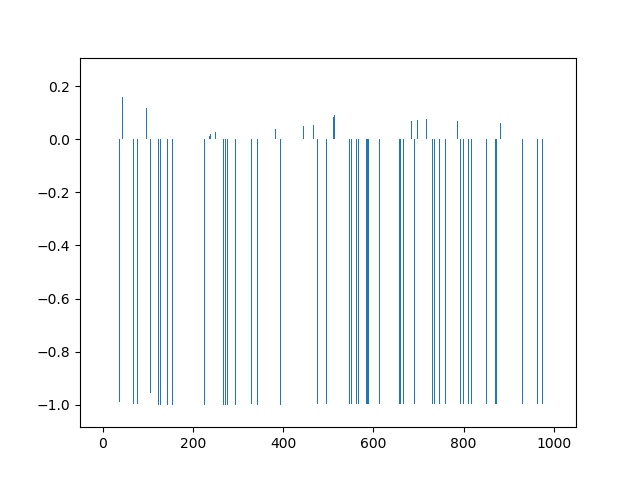

<BarContainer object of 1000 artists>

In [64]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.bar(np.arange(0, 1000), wrapper_1.r_buffer.T.flatten())

In this example r is sqrt(2) or 1/sqrt(2) or 0. Need to scale to -1, 0 and 1 > (r - 0.7ish)/0.7ish

In [65]:
wrapper_1.r_buffer.T.flatten()

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -1.        ,
        0.        ,  0.        ,  0.        , -1.        ,  0.        ,
        0.08250345,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.24418642,  0.        ,  0.        ,
        0.        , -0.92108374,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.98958254, -0.99383787,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.15729932,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.98855174, -0.99164442,  0.        ,  0.        , -0.99398714,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.99612473,  0.        ,  0.        ,
       -0.99677054,  0.        ,  0.        , -0.99723453,  0.  

In [66]:
wrapper_2.r_buffer.T.flatten()

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.37559537,  0.        ,  0.        ,
        0.        ,  0.91738589,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.95473596,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.97274335,  0.        ,  0.        ,  0.        ,  0.  

For wrapper_2 we have -sqrt(2), -1/sqrt(2), 0, sqrt(2) and +sqrt(2). This suggests probabilities - but do we need to scale first?

Also note the increase in 0s.

**What happens when we reconstruct with binary signals and not the values above?** We would need to apply the same scaling to the eigenvector.

In [67]:
print(wrapper_1.vpu.pi.eigenvector, wrapper_1.vpu.pi.eigenvalue, wrapper_1.vpu.cu.mean, sep="\n", end="\n\n")
print(np.dot(wrapper_1.vpu.pi.eigenvector, np.sqrt(wrapper_1.vpu.pi.eigenvalue))+wrapper_1.vpu.cu.mean)

[[0.99912654]
 [0.04178695]]
[[0.12429813]]
[[-0.147]
 [ 0.055]]

[[0.20525146]
 [0.06973238]]


In [68]:
print(np.dot(wrapper_1.vpu.pi.eigenvector, np.sqrt(wrapper_1.vpu.pi.eigenvalue)))

[[0.35225146]
 [0.01473238]]


Is the "feature" here then [-1, 1] and we need to scale and add the mean to get the feature (or then feature / feature.max?).

In [69]:
print(wrapper_1.vpu.pi.eigenvector, np.abs(wrapper_1.vpu.pi.eigenvector).max())

[[0.99912654]
 [0.04178695]] 0.9991265441445966


In [70]:
wrapper_1.vpu.pi.eigenvector / np.abs(wrapper_1.vpu.pi.eigenvector).max()

array([[1.        ],
       [0.04182348]])

In [71]:
wrapper_2.vpu.pi.eigenvector / np.abs(wrapper_2.vpu.pi.eigenvector).max()

array([[-0.07851312],
       [ 1.        ]])

**Divide by the largest value in the eigenvector then use the result as a probability?**

We only need to apply the PBT on the output.

**What about normalising the residual?**

The maximum distance in the space is 2 - -1 to 1. There is thus the chance for binary overflow -1 - (-1).

So the plan is:
* We normalise the eigenvector by dividing by the max entry (of the abs).
* We apply normalising and PBT to the r output.
* We normalise the residual (at the switch).

It would be good to do this and see if we get similar results to the test above.

In [72]:
print(wrapper_2.vpu.pi.eigenvector, wrapper_2.vpu.pi.eigenvalue, wrapper_2.vpu.cu.mean, sep="\n", end="\n\n")
print(np.dot(wrapper_2.vpu.pi.eigenvector, np.sqrt(wrapper_2.vpu.pi.eigenvalue))+wrapper_2.vpu.cu.mean)

[[-0.07827224]
 [ 0.99693202]]
[[0.06334939]]
[[-0.005]
 [ 0.066]]

[[-0.02470058]
 [ 0.31692087]]


When scaled does this relate to the Hadamard matrix - [-1, 1] and [1, 1]?

The variations from 1 indicate the patterns in the input (they are based on a data_in of [60, 190]).

In [73]:
 mean = np.asarray([128,128]).reshape(-1, 1); print(mean)

[[128]
 [128]]


In [74]:
ternary_input.dtype

dtype('int64')

In [75]:
pred.dtype; print(pred)

[[0.]
 [0.]]


In [76]:
residual.dtype; print(residual)

[[0]
 [0]]


In [77]:
np.asarray([[0,  1]])-np.asarray([[-0.,  1.]])

array([[0., 0.]])

In [78]:
wrapper_1.residual_buffer.max()

1.0

In [79]:
wrapper_1.residual_buffer.min()

-1.0

Is the accuracy associated with the lack of the -2 or 2 residuals? These tend to make it go haywire.

Do we clamp or normalise and PBT?

In [80]:
print(f"Max wrapper 2 residual: {wrapper_2.residual_buffer.max()}; min wrapper 2 residual: {wrapper_2.residual_buffer.min()}")

Max wrapper 2 residual: 1.0; min wrapper 2 residual: -1.0


In [81]:
print(vpu.cu.mean)

[[0.077     ]
 [0.20166667]]


Because we have a static value the CU mean is biased based on the static value. So we can ignore here - in real life we have variation so this should tend to 0 > need to check. If it is not 0 in real like we would need to constantly adapt such that it is 0.

In [82]:
print(np.sqrt(vpu.pi.eigenvalue))

[[0.60607629]]


In [83]:
from src.tests.vpu_wrapper import VPUWrapper

"""Use the VPU Wrapper to test advanced function."""
# Initialise two VPUs and wrappers
data_in = np.random.randint(255, size=(2, 1))
mean = np.asarray([128, 128]).reshape(-1, 1)
vpu_1 = VPU(2)
vpu_2 = VPU(2)
wrapper_1 = VPUWrapper(vpu_1)
wrapper_2 = VPUWrapper(vpu_2)
for _ in range(0, 1000):
    # First VPU
    ternary_input = signal_pre_processor(data_in, mean)
    _, _, residual = wrapper_1.iterate(ternary_input)
    # Second VPU
    _ = wrapper_2.iterate(residual)
est = (wrapper_1.pred_estimate*mean+mean)+(wrapper_2.pred_estimate*mean)
assert np.allclose(data_in, est, rtol=0.10, atol=10)
print(data_in, est)

[[139]
 [139]] [[139.277771  ]
 [137.02755202]]


### Signal Scaling

We have a number of options. We need scaling because:
* The maximum residual = 2\*max and the minimal residual = 2\*min. This will be 2x regardless of the length as we are only subtracting two values.
* The "unit length" eigenvalue is unit length in the zero mean, -1 to 1 space. This is actually sqrt(2) for 2D space, is sqrt(3) for 3D space and will be generally sqrt(L) where L is the segment length. We will also have both +ve and -ve values - so range is -sqrt(L) to sqrt(L).
    * So we could divide our output by the unit length to get in -1 to 1.

#### Ternary Signal Reconstruction

When we generate the signal:
* We subtract the mean - **m** from the signal_max.
* We compare +ve values with 0 to (signal_max-**m**).
* We take the absolute of -ve values and compare with 0 to **m**.
* Zeroes we just keep as zeros.

To reconstruct:
* We need to sum +ve and -ve values separately.
* We then reconstruct as m + (signal_max-m) x average(+ve values) - m x average(-ve values).

For the residuals:
* We have min residual = -2, max residual = 2 and zero mean. 
* For reconstruction we thus have 0 + (2) x average(+ve values) - (-2) x average(-ve values) > 2 x average of all values.

In [84]:
from src.var_processor.power_iterator import PowerIterator

In [85]:
def init_power(size):
    """Helper function."""
    # Test with length = size
    cov = np.random.randn(size, size)
    cov = np.dot(cov, cov.T)
    cov = cov / cov.max()
    # Generate test power iterator
    power = PowerIterator(size)
    power.load_covariance(cov)
    for _ in range(0, 1000):
        power.iterate()
    return power, cov

In [86]:
power, cov = init_power(3)

In [87]:
power.ev

array([[ 0.58225993],
       [ 0.8047285 ],
       [-0.11569536]])

In [88]:
power.ev

array([[ 0.58225993],
       [ 0.8047285 ],
       [-0.11569536]])

In [89]:
power.eigenvector

array([[ 0.58225993],
       [ 0.8047285 ],
       [-0.11569536]])

In [90]:
power.feature

array([[ 0.33616793],
       [ 0.46461021],
       [-0.06679675]])

In [91]:
power.feature*np.sqrt(3)

array([[ 0.58225993],
       [ 0.8047285 ],
       [-0.11569536]])

In [92]:
power.iterate()

array([[ 0.58225993],
       [ 0.8047285 ],
       [-0.11569536]])

In [93]:
power.feature.sum()

0.7339813952154296